In [62]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load Iris Dataset

In [63]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
df["y"] = iris["target"]
df["y"] = df["y"].map(dict(enumerate(iris.target_names)))

# Keep only rows where y is `Virginica` or `Versicolor`
df = df[df["y"].isin(["virginica", "versicolor"])]

# Keep only `sepal length (cm)` and `sepal width (cm)` columns

columns_to_keep = ["sepal length (cm)", "sepal width (cm)"]
df = df.loc[:, columns_to_keep + ["y"]]

In [64]:
print(f"Number of instances: {len(df)}")

Number of instances: 100


## Split Train/Test

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis=1), df["y"], test_size=0.3, random_state=42, stratify=df["y"]
)

## Preprocessing (Scaling)

Este paso realmente no es estrictamente necesario dado que las features que componen el conjunto de datos están en la misma escala (cm)

In [66]:
# Define the columns to be transformed
continuous_columns = X_train.select_dtypes(include=["float64"]).columns

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
    ]
)

# Aplicar las transformaciones
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train_virginica = X_train[y_train == "virginica"]
X_train_versicolor = X_train[y_train == "versicolor"]

X_train = pd.DataFrame(X_train, columns=continuous_columns)
X_test = pd.DataFrame(X_test, columns=continuous_columns)

---

## LDA/QDA Training

In [67]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

In [68]:
def plot_confusion_matrix(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=iris.target_names[1:]
    )
    disp.plot(cmap="Blues")
    plt.grid(False)
    plt.gca().set_frame_on(False)
    plt.show()


def display_decision_boundary(
    model: sklearn.base.BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    xlabel: str,
    ylabel: str,
    ax=None,
):
    """Display the decision boundary of a model.

    Parameters
    ----------
    model : sklearn.base.BaseEstimator
        Model to display the decision boundary of.
    X : pd.DataFrame
        Dataframe containing the features.
    y : pd.Series
        Series containing the target.
    xlabel : str
        Feature to display on the x-axis.
    ylabel : str
        Feature to display on the y-axis.
    ax : matplotlib.axes, optional
        The axes on which to plot. If None, a new figure will be created.
    """
    # Use provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the decision boundary
    disp = DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
        xlabel=xlabel,
        ylabel=ylabel,
        alpha=0.5,
        ax=ax,
    )

    # Add scatterplot
    sns.scatterplot(
        data=X,
        x=xlabel,
        y=ylabel,
        hue=y_test.reset_index(drop=True),  # Reset index to avoid misalignment
        alpha=0.5,
        ax=ax,
    )

    return disp


In [69]:
# This dictionary is needed to build a comparative DataFrame between models
models_accuracy_dict = {
    "Model": ["LDA", "QDA"],
    "Accuracy": [],
}

### LDA

In [70]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)

              precision    recall  f1-score   support

  versicolor       0.65      0.87      0.74        15
   virginica       0.80      0.53      0.64        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30



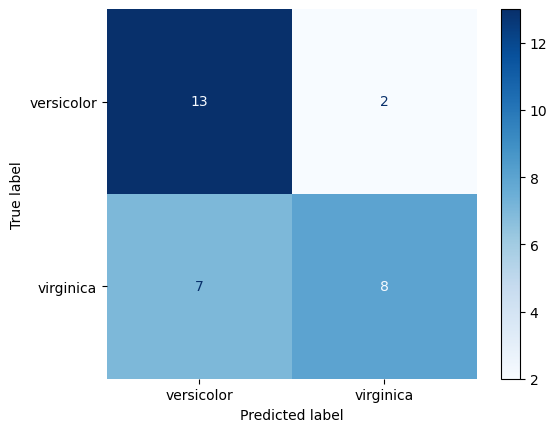

In [71]:
print(classification_report(y_test, y_pred_lda))
plot_confusion_matrix(y_test, y_pred_lda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_lda))

---

### QDA

In [72]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)

              precision    recall  f1-score   support

  versicolor       0.63      0.80      0.71        15
   virginica       0.73      0.53      0.62        15

    accuracy                           0.67        30
   macro avg       0.68      0.67      0.66        30
weighted avg       0.68      0.67      0.66        30



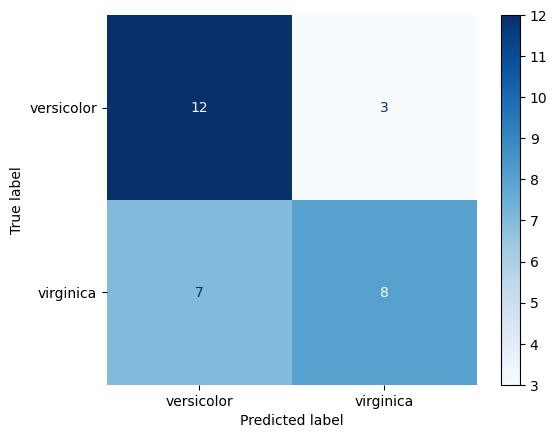

In [73]:
print(classification_report(y_test, y_pred_qda))
plot_confusion_matrix(y_test, y_pred_qda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_qda))

---

## Model Accuracy Comparision

In [74]:
pd.DataFrame(models_accuracy_dict)

,Model,Accuracy
0,LDA,0.700000
1,QDA,0.666667


Cualquiera de las tres variaciones de **RDA** obtuvieron el mismo Accuracy. **RDA** ofrece un 4% más de Accuracy que **LDA** y un 9.5% más que **QDA**. **QDA** es el método con menor Accuracy

## Display the Decision Boundary

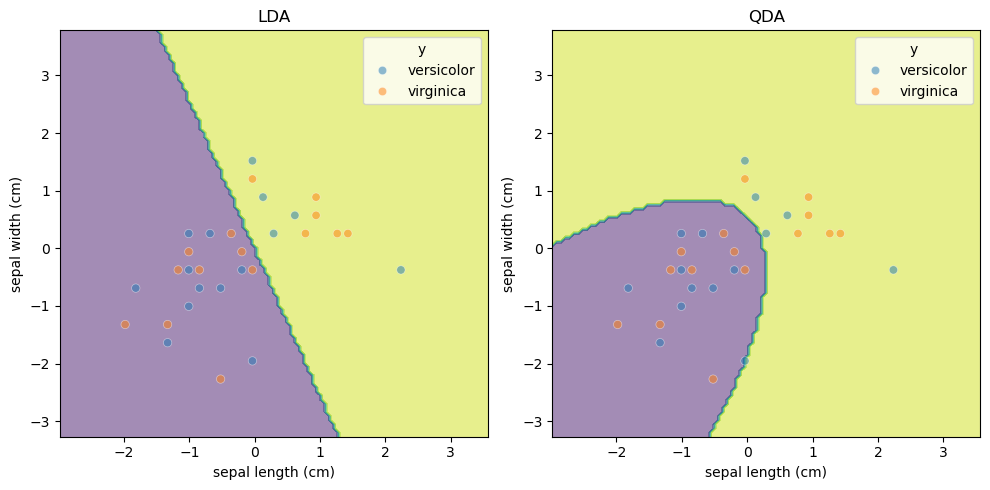

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

# Plot each model in a different subplot
models = {
    "LDA": lda,
    "QDA": qda,
}

for i, (name, model) in enumerate(models.items()):
    display_decision_boundary(
        model,
        X_train,
        y_train,
        "sepal length (cm)",
        "sepal width (cm)",
        ax=axes[i],
    )
    axes[i].set_title(f"{name}")

# Remove unused subplot if necessary
if len(models) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Kernel Density Estimation (KDE)

In [76]:
from sklearn.neighbors import KernelDensity

In [77]:
kde_parameters = {
    "bandwidth": [0.2, 0.5, 0.8],
    "kernel": ["gaussian", "tophat"],
}

In [78]:
kde_virginica = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(X_train_virginica)
kde_versicolor = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(X_train_versicolor)

In [79]:
# Define grid boundaries from the range of your data
x_min, x_max = (
    X_train["sepal length (cm)"].min() - 1,
    X_train["sepal length (cm)"].max() + 1,
)
y_min, y_max = (
    X_train["sepal width (cm)"].min() - 1,
    X_train["sepal width (cm)"].max() + 1,
)

# Create a grid with 100 points in each dimension
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Reshape the grid for KDE scoring
grid = np.c_[xx.ravel(), yy.ravel()]

# Now you can score samples on this grid
log_dens_virginica = kde_virginica.score_samples(grid)
log_dens_versicolor = kde_versicolor.score_samples(grid)
p_x_virginica = np.exp(log_dens_virginica)
p_x_versicolor = np.exp(log_dens_versicolor)

p_virginica = len(X_train_virginica) / len(X_train)
p_versicolor = len(X_train_versicolor) / len(X_train)

### Densidad Estimada

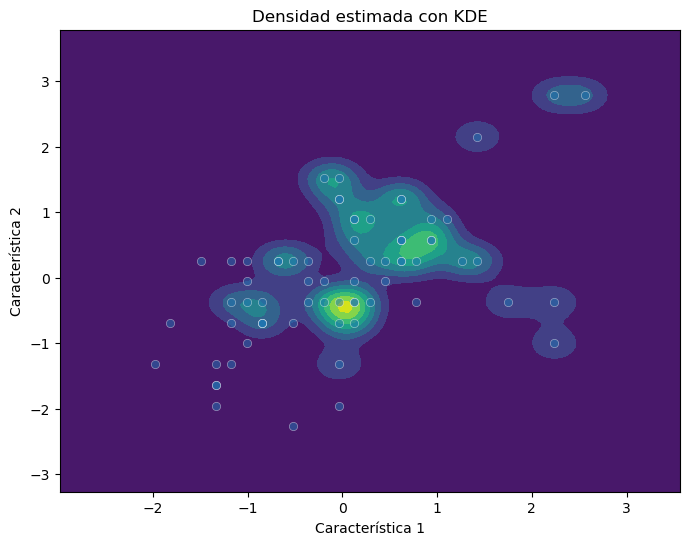

In [80]:
densidad_grid = p_x_virginica.reshape(xx.shape)

# Visualización de la densidad
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, densidad_grid, cmap="viridis")
sns.scatterplot(X_train, x="sepal length (cm)", y="sepal width (cm)", alpha=0.5)
plt.title("Densidad estimada con KDE")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

### Frontera de decisión

In [81]:
X_train_virginica = X_train[y_train.reset_index(drop=True) == "virginica"]
X_train_versicolor = X_train[y_train.reset_index(drop=True) == "versicolor"]

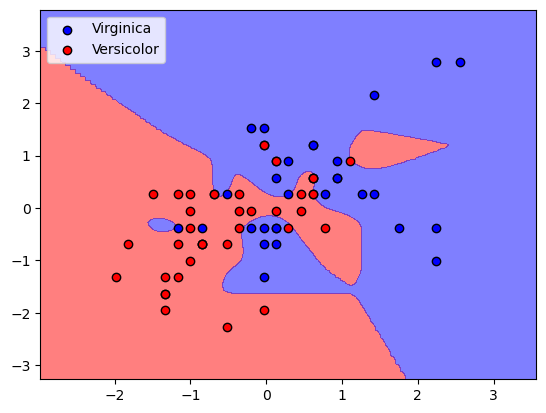

In [82]:
# Calculate discriminant functions
g_virginica = p_x_virginica * p_virginica
g_versicolor = p_x_versicolor * p_versicolor

# Difference of discriminant functions (the boundary is where this difference is zero)
diff = (g_virginica - g_versicolor).reshape(xx.shape)

plt.figure()
# We use `contourf` to color the regions according to the assigned class
plt.contourf(
    xx, yy, diff, levels=[-np.inf, 0, np.inf], alpha=0.5, colors=["red", "blue"]
)
plt.scatter(
    X_train_virginica.iloc[:, 0],
    X_train_virginica.iloc[:, 1],
    c="blue",
    edgecolor="k",
    label="Virginica",
)
plt.scatter(
    X_train_versicolor.iloc[:, 0],
    X_train_versicolor.iloc[:, 1],
    c="red",
    edgecolor="k",
    label="Versicolor",
)
# plt.title(f"Bandwidth: {bandwidth}, Kernel: {kernel}")
plt.legend()
plt.show()

## k-NN

In [87]:
from sklearn.neighbors import KNeighborsClassifier

k_list = [1, 3, 5, 7, 9, 11]
knn_models = {}
for k in k_list:
    # Train a KNN classifier with the current value of k
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train)

    knn_models[k] = knn

    y_pred = knn.predict(X_test)

    print(f"Accuracy {k}-NN: {accuracy_score(y_test, y_pred)}")

Accuracy 1-NN: 0.6333333333333333
Accuracy 3-NN: 0.6333333333333333
Accuracy 5-NN: 0.5666666666666667
Accuracy 7-NN: 0.6666666666666666
Accuracy 9-NN: 0.5666666666666667
Accuracy 11-NN: 0.6


### Metricas para 3-NN

              precision    recall  f1-score   support

  versicolor       0.62      0.67      0.65        15
   virginica       0.64      0.60      0.62        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



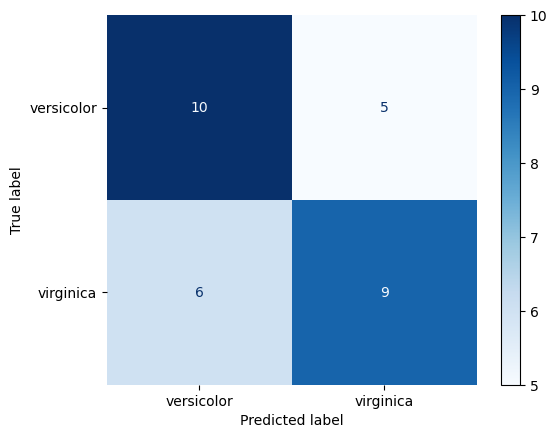

In [90]:
y_pred_5nn = knn_models[3].predict(X_test)
print(classification_report(y_test, y_pred_5nn))
plot_confusion_matrix(y_test, y_pred_5nn)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_5nn))

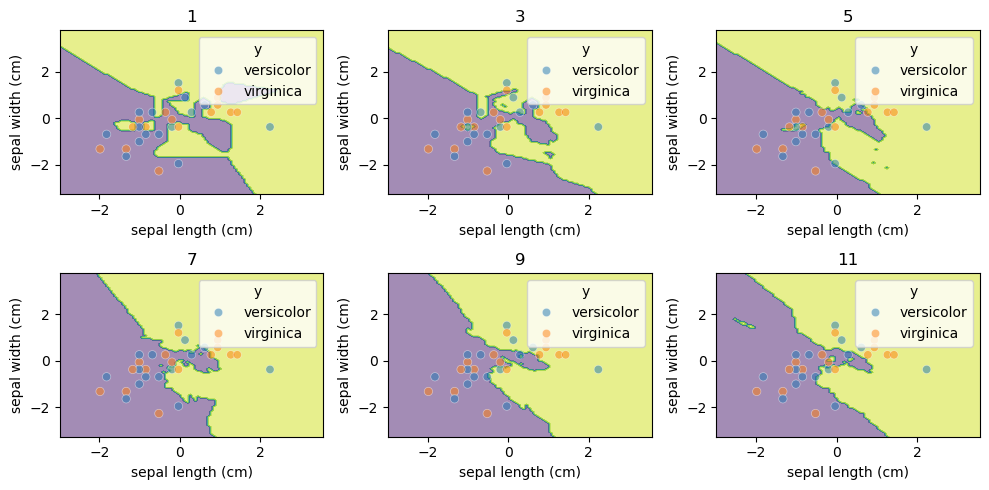

In [92]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()

for i, (k, model) in enumerate(knn_models.items()):
    display_decision_boundary(
        model,
        X_train,
        y_train,
        "sepal length (cm)",
        "sepal width (cm)",
        ax=axes[i],
    )
    axes[i].set_title(f"{k}")

# Remove unused subplot if necessary
if len(knn_models) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()